## A Spatio-Temporal Accessibility Analysis of Pharmacy Care in Vermont, USA
---

Extends and adapts studies *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x) AND Holler, J., Burt, D., Udoh, K., & Kedron, P. (2022). Reproduction and Reanalysis of Kang et al 2020 Spatial Accessibility of COVID-19 Health Care Resources. https://doi.org/10.17605/OSF.IO/N92V3



Authors: Sam Roubin, Joseph Holler, Peter Kedron

Reproduction Materials Available at: https://github.com/samroubin/VTPharmacy/tree/main

Created: `2024-01-14`
Revised: `2023-01-`

### Original Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) pharmacy information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available from the US Census Bureau on the [American Community Survey]. Lastly, hospital information available on our GitHub repository: 

### Modules
Import necessary libraries to run this model.
See `environment.yml` for the library versions used for this analysis.

In [417]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
import IPython
import requests
from IPython.display import display, clear_output
from shapely.ops import nearest_points   #for pharmacy_setting function
from scipy.stats import kruskal
from matplotlib.lines import Line2D

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
folium==0.12.1.post1
IPython==8.3.0
requests==2.27.1
seaborn==0.11.2


## Check Directories


In [3]:
# Check working directory
os.getcwd()

'/home/jovyan/work/VTPharmacy/procedure/code'

In [4]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/VTPharmacy'

## Load and Visualize Data

### Population by town for all states in study area (VT, NH, MA, NY)

In [5]:
# Read in population data by town
population_df = gpd.read_file('./data/raw/public/population/tidycensus_population.gpkg')
population_df.head()


# Read in metropolitan / micropolitan classifications (NECTAS)
nectas_df =  gpd.read_file('./data/raw/public/population/nectas.csv')
nectas_df.head()


# Join NECTAS classifications to population data with subdivision and county FIPS
pop_df = pd.merge(population_df, nectas_df[['fips_subdivision', 'necta', 'fips_county', 'fips_state']], on=['fips_subdivision','fips_county', 'fips_state'], how = 'left')
pop_df.head()

# Save as geopackage into public/derived
pop_df.to_file('./data//derived/public/pop_data.gpkg', driver='GPKG')

pop_df.head()

,GEOID,fips_state,fips_county,fips_subdivision,subdivision_name,total_pop,elderly_pop,pct_elderly,geometry,necta
0,5001773675,50,017,73675,"Tunbridge town, Orange County, Vermont",1337.0,189.0,14.136126,"POLYGON ((494016.737 152571.233, 494092.504 15...",NaN
1,5000975175,50,009,75175,"Victory town, Essex County, Vermont",70.0,19.0,27.142857,"POLYGON ((546966.722 227691.457, 547619.988 22...",NaN
2,5000902162,50,009,02162,"Avery's gore, Essex County, Vermont",0.0,0.0,NaN,"POLYGON ((551630.172 271974.320, 556994.743 27...",NaN
3,5000159650,50,001,59650,"Ripton town, Addison County, Vermont",739.0,145.0,19.621110,"POLYGON ((454852.030 171483.437, 457345.808 17...",NaN
4,5000108575,50,001,08575,"Bridport town, Addison County, Vermont",1225.0,284.0,23.183673,"POLYGON ((426786.611 165125.435, 426899.753 16...",NaN


<AxesSubplot:>

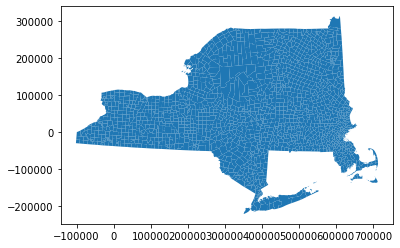

In [5]:
pop_df.plot()

### Load and Visualize Pharmacy Data

This data contains the hours of operations and the number of pharmacists and pharmacy technicians staffed at each pharmacy

In [6]:
# Read in pharmacy data
pharmacies = gpd.read_file('./data/raw/public/pharmacy/pharmacies.gpkg')
# pd.set_option('display.max_rows', None)
pharmacies.head()

,pharmid,pharmacy_name,type,address,state,lat,lon,week_open,week_close,sat_open,sat_close,sun_open,sun_close,geometry
0,MA25,Williamstown Apothecary,independent,"72 Spring St, Williamstown, MA 01267",MA,42.709965,-73.204387,8,18,8,14,9,13,POINT (-73.20439 42.70997)
1,MA26,Walgreens #18016,chain,"212 Main St, Williamstown, MA 01267",MA,42.702500,-73.183556,10,18,-1,-1,-1,-1,POINT (-73.18356 42.70250)
2,MA27,Stop and Shop #0784,grocery,"876 State Rd, North Adams, MA 01247",MA,42.699262,-73.165779,8,20,9,17,9,17,POINT (-73.16578 42.69926)
3,MA28,CVS #1131,chain,"55 Veterans Memorial Dr, North Adams, MA 01247",MA,42.701022,-73.111106,8,20,9,18,9,17,POINT (-73.11111 42.70102)
4,MA29,Walgreens #19525,chain,"50 Lincoln St, North Adams, MA 01247",MA,42.701025,-73.109574,9,19,9,18,9,17,POINT (-73.10957 42.70103)


In [7]:
# if pharmacy staffing file does not exist, download it from OSF 
if not os.path.exists("./data/raw/private/pharm_staffing.csv"):
    print("Loading pharmacy staffing levels", flush=True)
    url = 'https://osf.io/kbczp'
    r = requests.get(url, allow_redirects=True)
    open('./data/raw/private/pharm_staffing.csv', 'wb').write(r.content)
   
    
# Load pharmacy data from OSF project
pharm_staffing = pd.read_csv('./data/raw/private/pharm_staffing_interpolated.csv')

pharm_staffing.head()

,pharmid,week_pharm,week_tech,sat_pharm,sat_tech,sun_pharm,sun_tech
0,MA25,2,4,1,2,1,2
1,MA26,1,2,0,0,0,0
2,MA27,1,2,1,1,1,1
3,MA28,1,2,1,1,1,1
4,MA29,1,2,1,1,1,1


In [8]:
# Join private staffing data to pharmacies dataset (locations, hours of operations, etc.) 
pharmacies_df = pd.merge(pharmacies, pharm_staffing, on='pharmid', how = 'left')
pharmacies_df.head()


,pharmid,pharmacy_name,type,address,state,lat,lon,week_open,week_close,sat_open,sat_close,sun_open,sun_close,geometry,week_pharm,week_tech,sat_pharm,sat_tech,sun_pharm,sun_tech
0,MA25,Williamstown Apothecary,independent,"72 Spring St, Williamstown, MA 01267",MA,42.709965,-73.204387,8,18,8,14,9,13,POINT (-73.20439 42.70997),2,4,1,2,1,2
1,MA26,Walgreens #18016,chain,"212 Main St, Williamstown, MA 01267",MA,42.702500,-73.183556,10,18,-1,-1,-1,-1,POINT (-73.18356 42.70250),1,2,0,0,0,0
2,MA27,Stop and Shop #0784,grocery,"876 State Rd, North Adams, MA 01247",MA,42.699262,-73.165779,8,20,9,17,9,17,POINT (-73.16578 42.69926),1,2,1,1,1,1
3,MA28,CVS #1131,chain,"55 Veterans Memorial Dr, North Adams, MA 01247",MA,42.701022,-73.111106,8,20,9,18,9,17,POINT (-73.11111 42.70102),1,2,1,1,1,1
4,MA29,Walgreens #19525,chain,"50 Lincoln St, North Adams, MA 01247",MA,42.701025,-73.109574,9,19,9,18,9,17,POINT (-73.10957 42.70103),1,2,1,1,1,1


### Generate and Plot Map of Pharmacies

In [9]:
pharmacies_df.explore()

### Load the Road Network

If `Vermont_Network_Buffer.graphml` does not already exist, this cell will query the road network from OpenStreetMap.  

Each of the road network code blocks may take a few mintues to run.

In [10]:
%%time
# To create a new graph from OpenStreetMap, delete or rename the graph file (if it exists)
# AND set OSM to True
# This is more likely to work on a local computer than CyberGISX
# This network was created on Windows with Python 3.12.1 and osmnx 1.8.1 on 2024-01-24

OSM = False

# Define the place name for Vermont
place_name_vermont = 'Vermont, USA'

roads_path = "./data/raw/private/osm_roads.graphml"

# if buffered street network is not saved, and OSM is preferred, generate a new graph from OpenStreetMap and save it
if not os.path.exists(roads_path) and OSM:
    print("Loading buffered Vermont road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Vermont', network_type='drive', buffer_dist=64373.8) 
    print("Saving road network to", roads_path, " Please wait...", flush=True)
    ox.save_graphml(G, roads_path)
    print("Data saved.")
    
# otherwise, if buffered street network is not saved, download graph from the OSF project
elif not os.path.exists(roads_path):
    print("Downloading buffered Vermont road network from OSF...", flush=True)
    url = 'https://osf.io/download/n2q73/'  
    r = requests.get(url, allow_redirects=True)
    print("Saving road network to", roads_path, " Please wait...", flush=True)
    open(roads_path, 'wb').write(r.content)
    
# load the saved network graph
if os.path.exists(roads_path):
    print("Loading road network from", roads_path, "Please wait...", flush=True)
    G = ox.load_graphml(roads_path) 
    print("Data loaded.") 
else:
    print("Error: could not load the road network from file.")

Loading road network from ./data/raw/private/osm_roads.graphml Please wait...
Data loaded.
CPU times: user 1min 11s, sys: 3.74 s, total: 1min 15s
Wall time: 1min 15s


### Plot the Road Network

In [ ]:
%%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

#### Check speed limits and highway types

Display all the unique speed limit values and count how many network edges (road segments) have each value.
We will compare this to our cleaned network later.

In [11]:
%%time
# Turn network edges into a geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Count frequency of each speed value
speed_values = edges['maxspeed'].value_counts()

# Ouput number of edges and frequences of speed values
print(str(len(edges)) + " edges in graph")
print(speed_values.to_string())

577399 edges in graph
30 mph                                              48848
40                                                  20564
30                                                  18812
50                                                  15082
25 mph                                              14227
35 mph                                              10340
40 mph                                               9657
55 mph                                               6035
45 mph                                               5790
50 mph                                               3702
70                                                   2089
20 mph                                               1343
90                                                   1246
100                                                  1005
65 mph                                                722
[40 mph, 30 mph]                                      470
15 mph                                            

Display all the unique highway types, which are used to impute the speed limits for each category of highway.

In [13]:
# view all highway types
print(edges['highway'].value_counts())

residential                              383310
tertiary                                  65237
secondary                                 37717
primary                                   37419
unclassified                              37235
trunk                                      7176
motorway_link                              3150
motorway                                   1912
[residential, unclassified]                 939
primary_link                                833
tertiary_link                               659
secondary_link                              635
trunk_link                                  551
[residential, tertiary]                     152
living_street                               149
[tertiary, unclassified]                     50
[unclassified, tertiary]                     47
[secondary, tertiary]                        33
road                                         29
rest_area                                    26
busway                                  

The OSMNx algorithm to impute missing speed limit data assumes that units are kilometers per hour unless the units are specified.
Therefore, search for network edges containing speed limit data without units within the United States, where speed limits are defined in miles per hour.

### Process the road network

Impute speed limits with `add_edge_speeds` function. 

In [17]:
%%time
ox.speed.add_edge_speeds(G)

CPU times: user 20.7 s, sys: 426 ms, total: 21.1 s
Wall time: 21.1 s


Calculate travel time with the `add_edge_travel_times` function.

In [18]:
%%time
ox.speed.add_edge_travel_times(G)

CPU times: user 35.6 s, sys: 220 ms, total: 35.8 s
Wall time: 35.8 s


Add a point geomerty to each node in the graph, to facilitate constructing catchment area polygons later on.

In [19]:
%%time
# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])

CPU times: user 3.02 s, sys: 0 ns, total: 3.02 s
Wall time: 3.02 s


#### Check speed limits
Display all the unique speed limit values and count how many network edges (road segments) have each value.

In [20]:
%%time
# Turn network edges into a geodataframe
nodes,edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Count frequency of each speed value
speed_values = edges['speed_kph'].value_counts()

# Ouput number of edges and frequences of speed values
print(str(len(edges)) + " edges in graph")
print(speed_values.to_string())

577399 edges in graph
42.0     308419
48.3      48848
51.6      35227
50.1      32014
40.0      20732
30.0      18812
54.0      17268
50.0      15096
40.2      14227
63.9      14004
56.3      10340
64.4       9657
88.5       6035
72.4       5790
80.5       3702
70.0       2180
75.6       1729
67.6       1398
32.2       1343
90.0       1252
100.0      1006
80.0        812
104.6       722
60.0        720
55.2        514
56.0        507
68.0        483
24.1        467
72.0        419
45.6        391
35.0        370
52.0        333
62.1        320
76.0        286
64.0        281
47.7        278
16.1        161
44.0        145
48.0        137
33.5        117
112.7        79
20.0         76
57.0         72
45.0         71
84.0         50
75.0         49
25.0         45
67.0         39
85.0         38
65.0         36
61.0         27
15.0         26
36.0         21
96.3         20
108.0        19
8.0          18
96.0         17
96.6         16
10.0         14
27.4         14
69.0         12
27

In [41]:
edges.head()

osmid lanes                    name  \
u        v          key                                                        
61538824 8563892971 0                  8641726     1           Sawyer Street   
         61603465   0                  8642364     2             Dyer Street   
         61559482   0                  8642364     2             Dyer Street   
61540048 61616693   0    [1172898025, 8643013]     1       Timpany Boulevard   
         61620559   0                664932603     2  American Legion Circle   

                             highway width  oneway reversed   length  \
u        v          key                                                
61538824 8563892971 0    residential  12.2   False     True  142.321   
         61603465   0    residential  12.2   False    False  239.799   
         61559482   0    residential  12.2   False     True  222.688   
61540048 61616693   0      secondary  45.7    True    False   92.650   
         61620559   0      secondary  45.7    True    False   56.354   

                                                                  geometry  \
u        v          key                                                      
61538824 8563892971 0    LINESTRING (-71.99367 42.55663, -71.99404 42.5...   
         61603465   0    LINESTRING (-71.99367 42.55663, -71.99354 42.5...   
         61559482   0    LINESTRING (-71.99367 42.55663, -71.99375 42.5...   
61540048 61616693   0    LINESTRING (-71.99266 42.56605, -71.99255 42.5...   
         61620559   0    LINESTRING (-71.99266 42.56605, -71.99258 42.5...   

                         speed_kph  travel_time    ref    junction maxspeed  \
u        v          key                                                       
61538824 8563892971 0         42.0         12.2    NaN         NaN      NaN   
         61603465   0         42.0         20.6    NaN         NaN      NaN   
         61559482   0         42.0         19.1    NaN         NaN      NaN   
61540048 61616693   0         54.0          6.2  MA 68         NaN      NaN   
         61620559   0         54.0          3.8    NaN  roundabout      NaN   

                        bridge access tunnel service  
u        v          key                               
61538824 8563892971 0      NaN    NaN    NaN     NaN  
         61603465   0      NaN    NaN    NaN     NaN  
         61559482   0      NaN    NaN    NaN     NaN  
61540048 61616693   0      NaN    NaN    NaN     NaN  
         61620559   0      NaN    NaN    NaN     NaN

In [21]:
# These nodes were dropped because they were causing issues for creating the polygons around four pharmacies. 
# Instead, the polygons around these 4 pharmacies will form by snapping to the second nearest node.
nodes.drop([205007938, 5976921845,204567135,61755372], inplace = True)

Speeds have been imputed and converted to kilometers per hour.

In [22]:
# calculate a color scheme for edges based on speed
ec = ox.plot.get_edge_colors_by_attr(G, attr="speed_kph", cmap='viridis')

# plot edge speeds
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, bgcolor="white")

# note: the aesthetics of this could be improved!

KeyboardInterrupt: 

The graph of speed limits looks accurate, with local roads at low speeds and state and federal highways at higher speeds.

## "Helper" Functions

These functions are called when the model is run. 

### pharmacy_setting

Finds the nearest network node for each pharmacy.

Args:

* pharmacies: GeoDataFrame of pharmacies
* G: OSMNX network

Returns:

* GeoDataFrame of pharmacies with info on nearest network node

In [23]:
nodes_osmid = gpd.GeoDataFrame(nodes[["geometry"]]).reset_index()
nodes_osmid.head()

,osmid,geometry
0,61538824,POINT (-71.99367 42.55663)
1,61540048,POINT (-71.99266 42.56605)
2,61540293,POINT (-71.97358 42.55300)
3,61541585,POINT (-71.97150 42.55070)
4,61542977,POINT (-72.00436 42.56665)


In [25]:
pharmacies_osm = gpd.sjoin_nearest(pharmacies_df, nodes_osmid, distance_col="distances")

#rename column from osmid to nearest_osm, so that it works with other code
pharmacies_osm = pharmacies_osm.rename(columns={"osmid": "nearest_osm"})



### djikstra_cca_polygons

Function written by Joe Holler + Derrick Burt. A more efficient way to calculate distance-weighted catchment areas for each hospital in Holler et al. (2022). We use this method to calculate catchment areas for each pharmacy.  First, create a dictionary (with a node and its corresponding drive time from the hospital) of all nodes within a 30 minute drive time (using networkx single_cource_dijkstra_path_length function). From here, two more dictionaries are constructed by querying the original one. From these dictionaries, single part convex hulls are created for each drive time interval and appended into a single list (one list with 3 polygon geometries). Within the list, the polygons are differenced from each other to produce three catchment areas.

Args:
* G: cleaned network graph *with node point geometries attached*
* nearest_osm: A unique nearest node ID calculated for a single pharmacy
* distances: 3 distances (in drive time) to calculate catchment areas from

Returns:
* A list of 3 differenced (not-overlapping) catchment area polygons (10 min poly, 20 min poly, 30 min poly)

In [26]:
distances = [600, 1200, 1800] # Distances in travel time (seconds!)
weights = [1.0, 0.68, 0.22] 

# initialize catchment list, 3 empty geodataframes
catchments = []
for distance in distances:
    catchments.append(gpd.GeoDataFrame())
    
    
results = gpd.GeoDataFrame(columns = ["geometry","pharmid","weight"], crs = "EPSG:4326", geometry = "geometry")
for ind in pharmacies_osm.index:
    print("Working on pharmacy", pharmacies_osm['pharmid'][ind])
     ## CREATE DICTIONARIES ##
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, pharmacies_osm['nearest_osm'][ind], distances[2], "travel_time") # creating the largest graph from which 10 and 20 minute drive times can be extracted from

    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= distances[1]:
            nearest_nodes_20[key] = value
        if value <= distances[0]:
            nearest_nodes_10[key] = value

    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min) ##

    # 30 MIN
    # If the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # This line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # Re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # Create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    polygon_30["weight"] = weights[2]

    # 20 MIN # 1200 seconds!
    # Select nodes less than or equal to 20
    points_20 = points_30.query("z <= 1200")

    # Create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    polygon_20["weight"] = weights[1]

    # 10 MIN # 600 seconds!
    # Select nodes less than or equal to 10
    points_10 = points_30.query("z <= 600")

    # Create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    polygon_10["weight"] = weights[0]
    
    # Clip the overlapping distance ploygons (create two donuts + hole)
    polygon_30_hole = gpd.overlay(polygon_30, polygon_20, how ="difference")
    polygon_20_hole = gpd.overlay(polygon_20, polygon_10, how ="difference")
    
    # Create dataframe combining polygon_10, polygon_20, polygon_30
    polygons = pd.concat([polygon_10, polygon_20_hole, polygon_30_hole])
    polygons.set_crs(crs="EPSG:4326", inplace = True)
    # polygons = pd.concat([polygon_10, polygon_20, polygon_30])
    # polygons.set_crs(crs="EPSG:4326", inplace = True)
    
    
    polygons_gdf = polygons
    polygons_gdf["pharmid"] = pharmacies_osm['pharmid'][ind]
    #polygons_gdf["weight"] = weights

    results = pd.concat([results, polygons_gdf])

Working on pharmacy MA25
Working on pharmacy MA26
Working on pharmacy MA27
Working on pharmacy MA28
Working on pharmacy MA29
Working on pharmacy MA30
Working on pharmacy MA31
Working on pharmacy MA32
Working on pharmacy MA33
Working on pharmacy MA34
Working on pharmacy MA35
Working on pharmacy MA36
Working on pharmacy MA37
Working on pharmacy MA38
Working on pharmacy MA39
Working on pharmacy MA40
Working on pharmacy NH41
Working on pharmacy NH42
Working on pharmacy NH43
Working on pharmacy NH44
Working on pharmacy NH45
Working on pharmacy NH46
Working on pharmacy NH47
Working on pharmacy NH48
Working on pharmacy NH49
Working on pharmacy NH50
Working on pharmacy NH51
Working on pharmacy NH52
Working on pharmacy NH53
Working on pharmacy NH54
Working on pharmacy NH55
Working on pharmacy NH56
Working on pharmacy NH57
Working on pharmacy NH58
Working on pharmacy NH59
Working on pharmacy NH60
Working on pharmacy NH61
Working on pharmacy NH62
Working on pharmacy NH63
Working on pharmacy NH64


In [27]:
results.explore()

In [44]:
results.head() # There are 3 observations for each pharmid, which makes sense considering each pharm id should have a 10 min, 20 min, and 30 min polygon

,geometry,pharmid,weight
0,"POLYGON ((-73.22794 42.79213, -73.29797 42.857...",VT1,1.00
0,"POLYGON ((-73.21360 42.71208, -73.35281 42.766...",VT1,0.68
0,"POLYGON ((-73.36273 42.64824, -73.58442 42.778...",VT1,0.22
0,"POLYGON ((-73.11325 44.74660, -73.15627 44.806...",VT2,1.00
0,"POLYGON ((-73.17662 44.59076, -73.17735 44.591...",VT2,0.68


In [28]:
# Find for which pharmacies there are issues with geometry and thus their polygon catchments
summary_table = results['pharmid'].value_counts().reset_index()
print(summary_table.to_string())

# All pharmacies contain polygon 10,20, and 30. No Issues anymore. Used to be three pharmacies with only 1 geometry

     index  pharmid
0     MA25        3
1     MA26        3
2     VT35        3
3     VT36        3
4     VT37        3
5     VT38        3
6     VT39        3
7      VT4        3
8     VT40        3
9     VT41        3
10    VT42        3
11    VT43        3
12    VT44        3
13    VT45        3
14    VT46        3
15    VT47        3
16    VT48        3
17    VT49        3
18     VT5        3
19    VT50        3
20    VT51        3
21    VT52        3
22    VT53        3
23    VT33        3
24    VT32        3
25    VT31        3
26    VT21        3
27    VT14        3
28    VT15        3
29    VT16        3
30    VT17        3
31    VT18        3
32    VT19        3
33     VT2        3
34    VT24        3
35    VT20        3
36    VT22        3
37    VT75        3
38    VT23        3
39    VT25        3
40    VT26        3
41    VT27        3
42    VT28        3
43    VT29        3
44    VT34        3
45     VT3        3
46    VT30        3
47    VT54        3
48    VT55        3


In [29]:
# Change CRS to match 
results.to_crs("EPSG:6589", inplace = True)
pop_df.to_crs("EPSG:6589", inplace = True)

In [30]:
# Calculate town areas
pop_df['town_area'] = pop_df.geometry.area
#display(pop_df)

#results_clean['s_area'] = results_clean.geometry.area

# Run the overlay to find intersection of fragments
fragments = gpd.overlay(pop_df, results, how = 'intersection')

# Calculate fragment areas
fragments['frag_area'] = fragments.geometry.area

# Calculate area ratios
fragments['area_ratio']= fragments['frag_area'] / fragments['town_area']

# Calculate fragment value by multiplying area_ratio by distance weight
fragments['value'] = fragments['weight'] * fragments['area_ratio']

# Calculate population served in each fragment
fragments['pop_value'] = fragments['total_pop']*fragments['value']

fragments.head()
frag_inspect = fragments

# Sum population per pharmacy 
sum_values = fragments[["pharmid","pop_value"]]
sum_values = sum_values.groupby(by = ['pharmid']).sum('pop_value')
sum_values.rename(columns={'pop_value': 'total_value'}, inplace = True) 
sum_values.head()

# Join summed values by pharm to pharmacies_df
pop_join = sum_values.merge(pharmacies_df, on='pharmid', how = 'left')
pop_join.head()

,pharmid,total_value,pharmacy_name,type,address,state,lat,lon,week_open,week_close,...,sat_close,sun_open,sun_close,geometry,week_pharm,week_tech,sat_pharm,sat_tech,sun_pharm,sun_tech
0,MA25,43193.756964,Williamstown Apothecary,independent,"72 Spring St, Williamstown, MA 01267",MA,42.709965,-73.204387,8,18,...,14,9,13,POINT (-73.20439 42.70997),2,4,1,2,1,2
1,MA26,41629.628934,Walgreens #18016,chain,"212 Main St, Williamstown, MA 01267",MA,42.702500,-73.183556,10,18,...,-1,-1,-1,POINT (-73.18356 42.70250),1,2,0,0,0,0
2,MA27,38537.635337,Stop and Shop #0784,grocery,"876 State Rd, North Adams, MA 01247",MA,42.699262,-73.165779,8,20,...,17,9,17,POINT (-73.16578 42.69926),1,2,1,1,1,1
3,MA28,38322.283944,CVS #1131,chain,"55 Veterans Memorial Dr, North Adams, MA 01247",MA,42.701022,-73.111106,8,20,...,18,9,17,POINT (-73.11111 42.70102),1,2,1,1,1,1
4,MA29,38001.925251,Walgreens #19525,chain,"50 Lincoln St, North Adams, MA 01247",MA,42.701025,-73.109574,9,19,...,18,9,17,POINT (-73.10957 42.70103),1,2,1,1,1,1


In [242]:
# Calculate number of staff that work at each pharmacy
# Weekday
pop_join['week_staff'] = pop_join['week_pharm'] + 0.5 * pop_join['week_tech']

#Saturday
pop_join['sat_staff'] = pop_join['sat_pharm'] + 0.5 * pop_join['sun_tech']

# Sunday
pop_join['sun_staff'] = pop_join['sun_pharm'] + 0.5 * pop_join['sun_tech']

# Calculate service to pop ratio for each pharmacy at various days and times
# Weekday morning
pop_join['sp_ratio_w'] = pop_join['week_staff'] / pop_join['total_value']
pop_join['sp_ratio_7w'] = np.where(pop_join['week_open'] <= 7.5, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_8w'] = np.where(pop_join['week_open'] <= 8, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_9w'] = np.where(pop_join['week_open'] <= 9, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_10w'] = np.where(pop_join['week_open'] <= 10, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_11w'] = np.where(pop_join['week_open'] <= 11, pop_join['week_staff'] / pop_join['total_value'], np.nan)
# Weekday evening
pop_join['sp_ratio_14w'] = np.where(pop_join['week_close'] >= 14, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_15w'] = np.where(pop_join['week_close'] >= 15, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_16w'] = np.where(pop_join['week_close'] >= 16, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_17w'] = np.where(pop_join['week_close'] >= 17, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_18w'] = np.where(pop_join['week_close'] >= 18, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_19w'] = np.where(pop_join['week_close'] >= 19, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_20w'] = np.where(pop_join['week_close'] >= 20, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_21w'] = np.where(pop_join['week_close'] >= 21, pop_join['week_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_22w'] = np.where(pop_join['week_close'] >= 22, pop_join['week_staff'] / pop_join['total_value'], np.nan)

# Saturday morning
pop_join['sp_ratio_s'] = pop_join['sat_staff'] / pop_join['total_value']
pop_join['sp_ratio_7s'] = np.where(pop_join['sat_open'] <= 7, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_8s'] = np.where(pop_join['sat_open'] <= 8, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_9s'] = np.where(pop_join['sat_open'] <= 9, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_10s'] = np.where(pop_join['sat_open'] <= 10, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_11s'] = np.where(pop_join['sat_open'] <= 11, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
# Saturday evening
pop_join['sp_ratio_14s'] = np.where(pop_join['sat_close'] >= 14, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_15s'] = np.where(pop_join['sat_close'] >= 15, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_16s'] = np.where(pop_join['sat_close'] >= 16, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_17s'] = np.where(pop_join['sat_close'] >= 17, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_18s'] = np.where(pop_join['sat_close'] >= 18, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_19s'] = np.where(pop_join['sat_close'] >= 19, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_20s'] = np.where(pop_join['sat_close'] >= 20, pop_join['sat_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_21s'] = np.where(pop_join['sat_close'] >= 21, pop_join['sat_staff'] / pop_join['total_value'], np.nan) 
pop_join['sp_ratio_22s'] = np.where(pop_join['sat_close'] >= 22, pop_join['sat_staff'] / pop_join['total_value'], np.nan)

# Sunday morning
pop_join['sp_ratio_su'] = pop_join['sun_staff'] / pop_join['total_value']
pop_join['sp_ratio_8su'] = np.where(pop_join['sun_open'] <= 8, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_9su'] = np.where(pop_join['sun_open'] <= 9, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_10su'] = np.where(pop_join['sun_open'] <= 10, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_11su'] = np.where(pop_join['sun_open'] <= 11, pop_join['sun_staff'] / pop_join['total_value'], np.nan)

# Sunday evening
pop_join['sp_ratio_14su'] = np.where(pop_join['sun_close'] >= 14, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_15su'] = np.where(pop_join['sun_close'] >= 15, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_16su'] = np.where(pop_join['sun_close'] >= 16, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_17su'] = np.where(pop_join['sun_close'] >= 17, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_18su'] = np.where(pop_join['sun_close'] >= 18, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_19su'] = np.where(pop_join['sun_close'] >= 19, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_20su'] = np.where(pop_join['sun_close'] >= 20, pop_join['sun_staff'] / pop_join['total_value'], np.nan)
pop_join['sp_ratio_21su'] = np.where(pop_join['sun_close'] >= 21, pop_join['sun_staff'] / pop_join['total_value'], np.nan) 
pop_join['sp_ratio_22su'] = np.where(pop_join['sun_close'] >= 22, pop_join['sun_staff'] / pop_join['total_value'], np.nan)


# Join to the fragments df
frag_join = fragments.merge(pop_join, on = 'pharmid', how = 'left')

In [256]:
# Calculate weighted service to population ratio for each slice of time
# Weekday
frag_join['sp_weighted_w'] = frag_join['sp_ratio_w']*frag_join['weight']
frag_join['sp_weighted_7w'] = frag_join['sp_ratio_7w']*frag_join['weight']
frag_join['sp_weighted_8w'] = frag_join['sp_ratio_8w']*frag_join['weight']
frag_join['sp_weighted_9w'] = frag_join['sp_ratio_9w']*frag_join['weight']
frag_join['sp_weighted_10w'] = frag_join['sp_ratio_10w']*frag_join['weight']

frag_join['sp_weighted_17w'] = frag_join['sp_ratio_17w']*frag_join['weight']
frag_join['sp_weighted_18w'] = frag_join['sp_ratio_18w']*frag_join['weight']
frag_join['sp_weighted_19w'] = frag_join['sp_ratio_19w']*frag_join['weight']
frag_join['sp_weighted_20w'] = frag_join['sp_ratio_20w']*frag_join['weight']
frag_join['sp_weighted_21w'] = frag_join['sp_ratio_20w']*frag_join['weight']
frag_join['sp_weighted_22w'] = frag_join['sp_ratio_20w']*frag_join['weight']
# Saturday
frag_join['sp_weighted_s'] = frag_join['sp_ratio_s']*frag_join['weight']
frag_join['sp_weighted_8s'] = frag_join['sp_ratio_8s']*frag_join['weight']
frag_join['sp_weighted_9s'] = frag_join['sp_ratio_9s']*frag_join['weight']
frag_join['sp_weighted_10s'] = frag_join['sp_ratio_10s']*frag_join['weight']
frag_join['sp_weighted_17s'] = frag_join['sp_ratio_17s']*frag_join['weight']
frag_join['sp_weighted_18s'] = frag_join['sp_ratio_18s']*frag_join['weight']
frag_join['sp_weighted_19s'] = frag_join['sp_ratio_19s']*frag_join['weight']
frag_join['sp_weighted_20s'] = frag_join['sp_ratio_20s']*frag_join['weight']
frag_join['sp_weighted_21s'] = frag_join['sp_ratio_21s']*frag_join['weight']
frag_join['sp_weighted_22s'] = frag_join['sp_ratio_22s']*frag_join['weight']

# Sunday
frag_join['sp_weighted_su'] = frag_join['sp_ratio_su']*frag_join['weight']
frag_join['sp_weighted_8su'] = frag_join['sp_ratio_8su']*frag_join['weight']
frag_join['sp_weighted_9su'] = frag_join['sp_ratio_9su']*frag_join['weight']
frag_join['sp_weighted_10su'] = frag_join['sp_ratio_9su']*frag_join['weight']
frag_join['sp_weighted_11su'] = frag_join['sp_ratio_9su']*frag_join['weight']
frag_join['sp_weighted_14su'] = frag_join['sp_ratio_14su']*frag_join['weight']
frag_join['sp_weighted_15su'] = frag_join['sp_ratio_15su']*frag_join['weight']
frag_join['sp_weighted_16su'] = frag_join['sp_ratio_16su']*frag_join['weight']
frag_join['sp_weighted_17su'] = frag_join['sp_ratio_17su']*frag_join['weight']
frag_join['sp_weighted_18su'] = frag_join['sp_ratio_18su']*frag_join['weight']
frag_join['sp_weighted_19su'] = frag_join['sp_ratio_19su']*frag_join['weight']
frag_join['sp_weighted_20su'] = frag_join['sp_ratio_20su']*frag_join['weight']
frag_join['sp_weighted_21su'] = frag_join['sp_ratio_21su']*frag_join['weight']
frag_join['sp_weighted_22su'] = frag_join['sp_ratio_22su']*frag_join['weight']

# Make all NaN values 0, since these values represent 0 access
frag_join.fillna(0, inplace = True)

# Sum weighted service to population ratio by town
#frag_join = frag_join[['GEOID','sp_weighted_w','sp_weighted_7w', 'sp_weighted_8w', 'sp_weighted_9w', 'sp_weighted_10w', 'sp_weighted_17w', 'sp_weighted_18w', 'sp_weighted_19w', 'sp_weighted_20w', 'sp_weighted_21w', 'sp_weighted_22w', 'sp_weighted_s', 'sp_weighted_su']]
accessibility_towns = frag_join.groupby('GEOID').sum()

In [213]:
frag_join.head()

,GEOID,sp_weighted_w,sp_weighted_7w,sp_weighted_8w,sp_weighted_9w,sp_weighted_10w,sp_weighted_17w,sp_weighted_18w,sp_weighted_19w,sp_weighted_20w,sp_weighted_21w,sp_weighted_22w,sp_weighted_s,sp_weighted_su
0,5001773675,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0,0.0,0.0,0.000005,0.000005
1,5001758075,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0,0.0,0.0,0.000005,0.000005
2,5002708275,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0,0.0,0.0,0.000005,0.000005
3,5002763775,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0,0.0,0.0,0.000005,0.000005
4,5002758375,0.000007,0.0,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.0,0.0,0.0,0.000005,0.000005


In [252]:
pd.set_option('display.max_rows', None)
accessibility_towns.head()

,total_pop,elderly_pop,pct_elderly,town_area,weight,frag_area,area_ratio,value,pop_value,total_value,...,sp_weighted_11su,sp_weighted_14su,sp_weighted_15su,sp_weighted_16su,sp_weighted_17su,sp_weighted_18su,sp_weighted_19su,sp_weighted_20su,sp_weighted_21su,sp_weighted_22su
GEOID,,,,,,,,,,,,,,,,,,,,,
2500300555,138822.0,0.0,0.0,1.010786e+09,10.86,4.187102e+08,7.042120,5.303240,43306.257963,675510.226639,...,0.000248,0.000272,0.000272,0.000272,0.000272,0.000066,0.0,0.0,0.0,0.0
2500313345,48870.0,0.0,0.0,1.068931e+09,8.08,4.988343e+08,7.000000,3.768629,12278.194860,599935.985662,...,0.000147,0.000180,0.000180,0.000180,0.000180,0.000074,0.0,0.0,0.0,0.0
2500314010,41425.0,0.0,0.0,8.276701e+08,15.10,4.193126e+08,12.665451,7.098249,11761.799384,962771.059942,...,0.000322,0.000326,0.000318,0.000318,0.000300,0.000075,0.0,0.0,0.0,0.0
2500316180,56970.0,0.0,0.0,5.098868e+08,2.90,2.404950e+08,4.244972,1.250382,7914.917953,361871.348822,...,0.000036,0.000061,0.000061,0.000061,0.000061,0.000035,0.0,0.0,0.0,0.0
2500324120,14574.0,0.0,0.0,1.337749e+09,9.40,4.853115e+08,7.618424,3.564267,2473.601233,801912.353934,...,0.000248,0.000259,0.000259,0.000259,0.000242,0.000035,0.0,0.0,0.0,0.0


In [257]:
#Normalize (multiply by large constant)
#Full Days
accessibility_towns['access_w'] = accessibility_towns['sp_weighted_w']*10000
accessibility_towns['access_s'] = accessibility_towns['sp_weighted_s']*10000
accessibility_towns['access_su'] = accessibility_towns['sp_weighted_su']*10000

# Weekday times
accessibility_towns['access_7w'] = accessibility_towns['sp_weighted_7w']*10000
accessibility_towns['access_8w'] = accessibility_towns['sp_weighted_8w']*10000
accessibility_towns['access_9w'] = accessibility_towns['sp_weighted_9w']*10000
accessibility_towns['access_10w'] = accessibility_towns['sp_weighted_10w']*10000
accessibility_towns['access_17w'] = accessibility_towns['sp_weighted_17w']*10000
accessibility_towns['access_18w'] = accessibility_towns['sp_weighted_18w']*10000
accessibility_towns['access_19w'] = accessibility_towns['sp_weighted_19w']*10000
accessibility_towns['access_20w'] = accessibility_towns['sp_weighted_20w']*10000
accessibility_towns['access_21w'] = accessibility_towns['sp_weighted_22w']*10000

# Saturday times
accessibility_towns['access_8s'] = accessibility_towns['sp_weighted_8s']*10000
accessibility_towns['access_9s'] = accessibility_towns['sp_weighted_9s']*10000
accessibility_towns['access_10s'] = accessibility_towns['sp_weighted_10s']*10000
accessibility_towns['access_17s'] = accessibility_towns['sp_weighted_17s']*10000
accessibility_towns['access_18s'] = accessibility_towns['sp_weighted_18s']*10000
accessibility_towns['access_19s'] = accessibility_towns['sp_weighted_19s']*10000
accessibility_towns['access_20s'] = accessibility_towns['sp_weighted_20s']*10000
accessibility_towns['access_21s'] = accessibility_towns['sp_weighted_21s']*10000
accessibility_towns['access_22s'] = accessibility_towns['sp_weighted_22s']*10000

# Sunday times
accessibility_towns['access_8su'] = accessibility_towns['sp_weighted_8su']*10000
accessibility_towns['access_9su'] = accessibility_towns['sp_weighted_9su']*10000
accessibility_towns['access_10su'] = accessibility_towns['sp_weighted_10su']*10000
accessibility_towns['access_11su'] = accessibility_towns['sp_weighted_11su']*10000
accessibility_towns['access_14su'] = accessibility_towns['sp_weighted_14su']*10000
accessibility_towns['access_15su'] = accessibility_towns['sp_weighted_15su']*10000
accessibility_towns['access_16su'] = accessibility_towns['sp_weighted_16su']*10000
accessibility_towns['access_17su'] = accessibility_towns['sp_weighted_17su']*10000
accessibility_towns['access_18su'] = accessibility_towns['sp_weighted_18su']*10000
accessibility_towns['access_19su'] = accessibility_towns['sp_weighted_19su']*10000
accessibility_towns['access_20su'] = accessibility_towns['sp_weighted_20su']*10000
accessibility_towns['access_21su'] = accessibility_towns['sp_weighted_21su']*10000
accessibility_towns['access_22su'] = accessibility_towns['sp_weighted_22su']*10000


# accessibility_columns =  ['GEOID'] + [col for col in accessibility_towns.columns if col.startswith('access')] 
# accessibility_towns = df[accessibility_columns]
accessibility_towns = accessibility_towns[[col for col in accessibility_towns.columns if col.startswith('access')]]
accessibility_towns.head()


,access_w,access_s,access_su,access_7w,access_8w,access_9w,access_10w,access_17w,access_18w,access_19w,...,access_11su,access_14su,access_15su,access_16su,access_17su,access_18su,access_19su,access_20su,access_21su,access_22su
GEOID,,,,,,,,,,,,,,,,,,,,,
2500300555,6.084474,3.192198,3.133571,0.0,3.571747,5.652089,6.084474,6.084474,6.084474,3.622459,...,2.476969,2.716844,2.716844,2.716844,2.716844,0.656602,0.0,0.0,0.0,0.0
2500313345,4.453023,2.217140,2.217140,0.0,2.760345,4.020639,4.453023,4.453023,4.453023,2.400551,...,1.474554,1.800413,1.800413,1.800413,1.800413,0.742586,0.0,0.0,0.0,0.0
2500314010,9.598507,4.433280,4.141331,0.0,4.742115,8.791389,9.598507,9.598507,9.598507,4.361397,...,3.219523,3.261574,3.177003,3.177003,3.001822,0.746627,0.0,0.0,0.0,0.0
2500316180,1.544613,0.712198,0.712198,0.0,0.901724,1.438919,1.544613,1.544613,1.544613,0.813775,...,0.360447,0.610331,0.610331,0.610331,0.610331,0.351751,0.0,0.0,0.0,0.0
2500324120,5.767465,3.127962,3.008188,0.0,3.005710,5.335081,5.767465,5.767465,5.767465,3.426085,...,2.481256,2.591461,2.591461,2.591461,2.416280,0.351751,0.0,0.0,0.0,0.0


In [323]:
# Join back to geometries in pop_df for mapping
mapping_df = pd.merge(accessibility_towns, pop_df[['GEOID', 'geometry', 'fips_state', 'necta', 'pct_elderly']], on='GEOID', how='left')
mapping_df = mapping_df[mapping_df['fips_state'].isin(['50'])]
mapping_df = gpd.GeoDataFrame(mapping_df, crs="EPSG:6589", geometry='geometry')
mapping_df.explore()

## Results

### Hypothesis 1

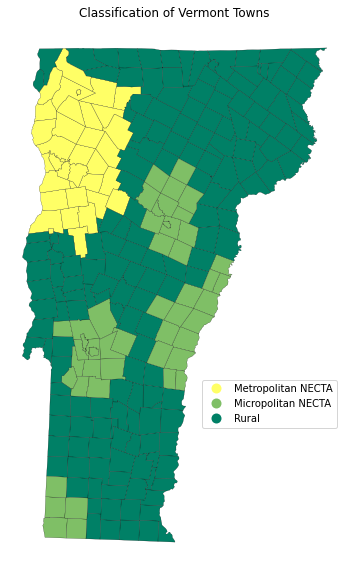

In [402]:
# Map of NECTA classifications
legend_colors = {'Metropolitan NECTA': 'darkblue', 'Micropolitan NECTA': 'royalblue', 'Rural': 'forestgreen'}

fig, ax = plt.subplots(figsize=(10, 10))
mapping_df.plot(column='necta', categorical=True, legend=True, legend_kwds={'loc': 'center right', 'bbox_to_anchor': (1, 0.3)}, ax=ax, edgecolor = 'black', linewidth = .2, cmap = 'summer_r')
plt.title('Classification of Vermont Towns')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')
plt.show()

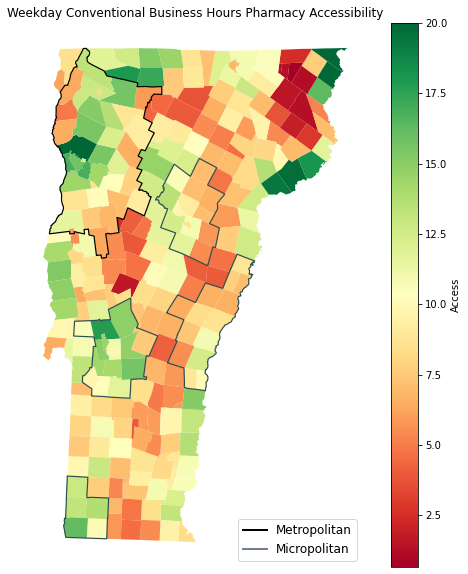

In [425]:
metropolitan_df = mapping_df[mapping_df['necta'] == 'Metropolitan NECTA']
micropolitan_df = mapping_df[mapping_df['necta'] == 'Micropolitan NECTA']

# Dissolve the geometries for each group to merge adjacent polygons
metropolitan_boundary = metropolitan_df.dissolve(by='necta')['geometry'].boundary
micropolitan_boundary = micropolitan_df.dissolve(by='necta')['geometry'].boundary

# Plot the map of weekday pharmacy accessibility
fig, ax = plt.subplots(figsize=(10, 10))
#legend_kwds = dict(orientation='horizontal', label='Access', pad=-0.5, loc = 'lower right')
mapping_df.plot(column='access_w', cmap='RdYlGn', legend=True, legend_kwds={'label':'Access','orientation': 'vertical'}, ax=ax, vmax=20)

# Plot only the merged exterior boundaries of the 'Metropolitan NECTA' group
metropolitan_boundary.plot(ax=ax, color='black', linewidth=1.2)

# Plot only the merged exterior boundaries of the 'Micropolitan NECTA' group
micropolitan_boundary.plot(ax=ax, color='darkslategrey', linewidth=1.2)

legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Metropolitan'),
    Line2D([0], [0], color='slategrey', lw=2, label='Micropolitan')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=12)

plt.title('Weekday Conventional Business Hours Pharmacy Accessibility')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('off')
plt.show()

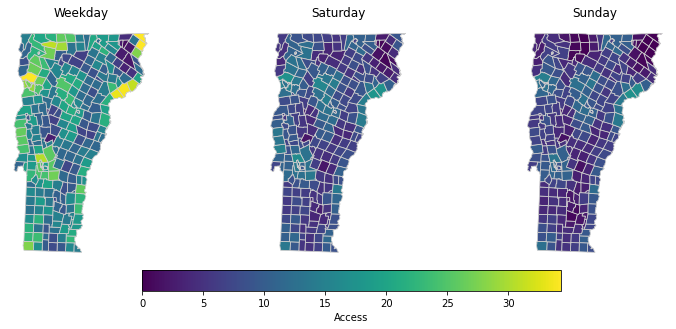

In [360]:
# Map by day of the week
mapping_df1 = mapping_df
min_val = mapping_df1[['access_w', 'access_s', 'access_su']].min().min()
max_val = mapping_df1[['access_w', 'access_s', 'access_su']].max().max()

#Winsorize Data 
p95_w = mapping_df1['access_w'].quantile(0.95)
mapping_df1['access_w_windsor'] = mapping_df1['access_w'].where(mapping_df1['access_w'] <= p95_w, p95_w)

p95_s = mapping_df1['access_s'].quantile(0.95)
mapping_df1['access_s_windsor'] = mapping_df1['access_s'].where(mapping_df1['access_s'] <= p95_s, p95_s)

p95_su = mapping_df1['access_su'].quantile(0.95)
mapping_df1['access_su_windsor'] = mapping_df1['access_su'].where(mapping_df1['access_su'] <= p95_su, p95_su)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=-.69)

for i, column in enumerate(['access_w', 'access_s', 'access_su']):
    ax = axs[i]
    mapping_df1.plot(column=column, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False,
                vmin=min_val, vmax=20)
    axs[0].set_title('Weekday')
    axs[1].set_title('Saturday')
    axs[2].set_title('Sunday')
    ax.axis('off')
    
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min_val, vmax=max_val), cmap='viridis'), ax=axs, 
                    orientation='horizontal', pad=-.45, shrink = .5)
cbar.set_label('Access')
    
plt.tight_layout()
plt.show()

# move this to hypothesis 2

7.49949889244838 3.6313547904254744 2.909526520403624
                     access_w  access_s  access_su
necta                                             
Metropolitan NECTA  10.734148  5.452278   4.167715
Micropolitan NECTA  10.386061  5.672006   4.984102
Rural                8.723353  4.278283   3.292892


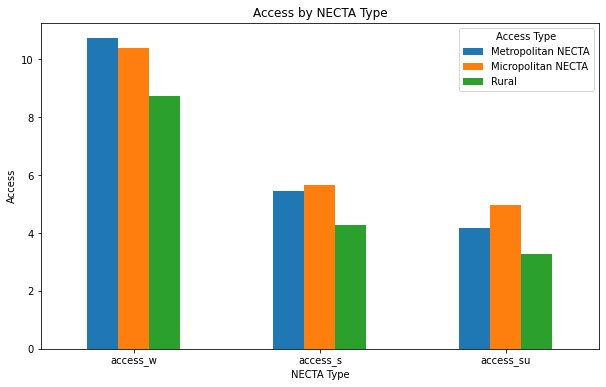

In [324]:
# Average Accessibility by Day and NECTA
mapping_df['necta'].fillna('Rural', inplace=True)
means_by_metro = mapping_df.groupby('necta').mean()
means_by_metro = means_by_metro[['access_w','access_s','access_su']]
print(means_by_metro)

# Make bar graph
means_by_metro_transposed = means_by_metro.T
means_by_metro_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Access by NECTA Type')
plt.xlabel('NECTA Type')
plt.ylabel('Access')
plt.xticks(rotation=0) 
plt.legend(title='Access Type')
plt.show()

# Report numbers for weekday
# Run sat rural / w rural and sat urban / w urban 

#### Statistical Significance

In [ ]:
# Check for normal distribution in weekday metro, micro, rural
access_w_metro = mapping_df[mapping_df['necta'] == 'Metropolitan NECTA']['access_w']
access_w_micro = mapping_df[mapping_df['necta'] == 'Micropolitan NECTA']['access_w']
access_w_rural = mapping_df[mapping_df['necta'] == 'Rural']['access_w']

print(plt.hist(access_w_metro, bins=10)) 
print(plt.hist(access_w_micro, bins=10)) 
print(plt.hist(access_w_rural, bins=10))

In [347]:
# Kruskal Wallis Test for significant difference of means
h_statistic, p_value = kruskal(access_w_metro, access_w_micro, access_w_rural)
                 
print("Kruskal-Wallis H Statistic:", h_statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean access during conventional weekday \nbusiness hours between metropolitan, micropolitan, and rural towns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean access between groups.")
                                                                                      

Kruskal-Wallis H Statistic: 15.208957563220906
P-value: 0.0004982150326773178
Reject the null hypothesis. There is a significant difference in mean access during conventional weekday 
business hours between metropolitan, micropolitan, and rural towns.


### Hypothesis 2 

#### Accessibility variation by day of the week

In [458]:
mapping_df[['access_w', 'access_s', 'access_su']].mean()

access_w     9.312325
access_s     4.701767
access_su    3.731311
dtype: float64

0.0
34.29089107704414


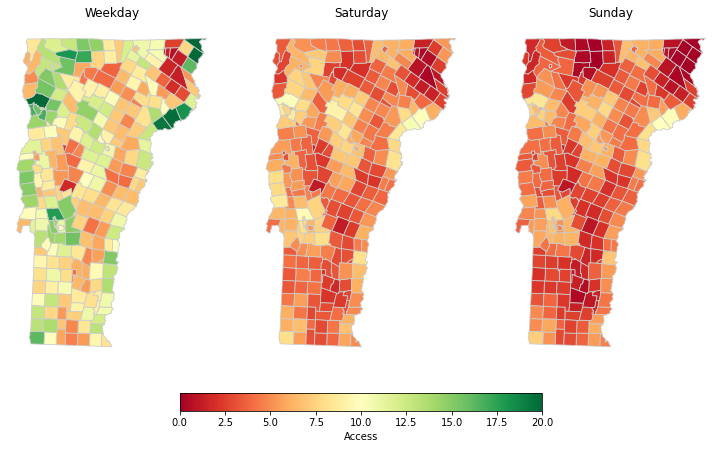

In [460]:
# Map by day of the week
mapping_df1 = mapping_df
print(mapping_df1[['access_w', 'access_s', 'access_su']].min().min())  # Min accessibility value
print(mapping_df1[['access_w', 'access_s', 'access_su']].max().max())  # Max accessibility value

fig, axs = plt.subplots(1, 3, figsize=(13, 8))
plt.subplots_adjust(wspace=.1)

for i, column in enumerate(['access_w', 'access_s', 'access_su']):
    ax = axs[i]
    mapping_df1.plot(column=column, cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False,
                vmin=0, vmax=20)
    axs[0].set_title('Weekday')
    axs[1].set_title('Saturday')
    axs[2].set_title('Sunday')
    ax.axis('off')
    
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=20), cmap='RdYlGn'), ax=axs, 
                    orientation='horizontal', pad = .07, shrink = .5)
cbar.set_label('Access')
    
#plt.tight_layout()
plt.show()

#### Accessibility by time of day

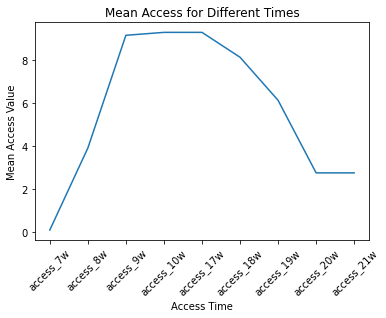

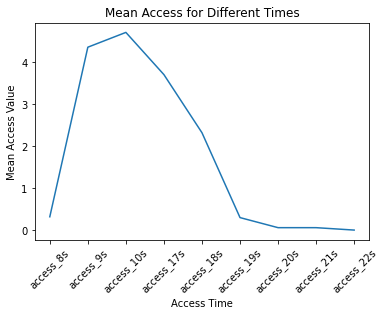

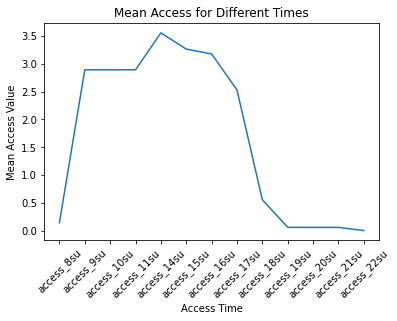

In [463]:
bargraph_df = mapping_df.copy()  
bargraph_df['necta'].fillna('Rural', inplace=True) 

bargraph_df.head()

# Weekday
access_columns_w = ['access_7w','access_8w','access_9w','access_10w', 'access_17w', 'access_18w', 'access_19w', 'access_20w', 'access_21w']
values_w = bargraph_df[access_columns_w].mean()  # Calculate the mean value for each access column

plt.plot(access_columns_w, values_w)
plt.title('Mean Access for Different Times')
plt.xlabel('Access Time')
plt.ylabel('Mean Access Value')
plt.xticks(rotation=45) 
plt.show()

# Saturday
access_columns_s = ['access_8s','access_9s','access_10s', 'access_17s', 'access_18s', 'access_19s', 'access_20s', 'access_21s', 'access_22s']
values_s = bargraph_df[access_columns_s].mean()  # Calculate the mean value for each access column

plt.plot(access_columns_s, values_s)
plt.title('Mean Access for Different Times')
plt.xlabel('Access Time')
plt.ylabel('Mean Access Value')
plt.xticks(rotation=45) 
plt.show()


# Sunday
access_columns_su = ['access_8su','access_9su','access_10su', 'access_11su', 'access_14su', 'access_15su', 'access_16su', 'access_17su', 'access_18su', 'access_19su', 'access_20su', 'access_21su', 'access_22su']
values_su = bargraph_df[access_columns_su].mean()  # Calculate the mean value for each access column

plt.plot(access_columns_su, values_su)
plt.title('Mean Access for Different Times')
plt.xlabel('Access Time')
plt.ylabel('Mean Access Value')
plt.xticks(rotation=45) 
plt.show()



7.49949889244838 3.6313547904254744 2.909526520403624


(array([129.,  65.,  77.,  73.,  66.,  36.,  27.,  14.,   8.,   3.]),
 array([ 0.        ,  1.002513  ,  2.00502601,  3.00753901,  4.01005202,
         5.01256502,  6.01507803,  7.01759103,  8.02010403,  9.02261704,
        10.02513004]),
 <BarContainer object of 10 artists>)

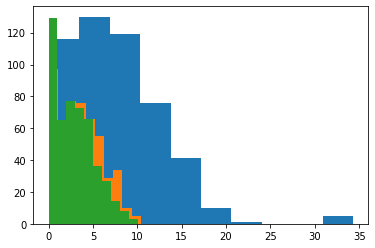

In [326]:
# Calculate average accessibility for Weeekday, Sat, Sun
print(accessibility_towns['access_w'].mean(), accessibility_towns['access_s'].mean(), accessibility_towns['access_su'].mean())

# Check for normal distribution between days of week
plt.hist(accessibility_towns['access_w'], bins=10) 
plt.hist(accessibility_towns['access_s'], bins=10) 
plt.hist(accessibility_towns['access_su'], bins=10) 

# Run Kruskall Wallis Test

### Hypothesis 3

#### Days of Week by Classification

                     access_w  access_s  access_su
necta                                             
Metropolitan NECTA  10.734148  5.452278   4.167715
Micropolitan NECTA  10.386061  5.672006   4.984102
Rural                8.723353  4.278283   3.292892


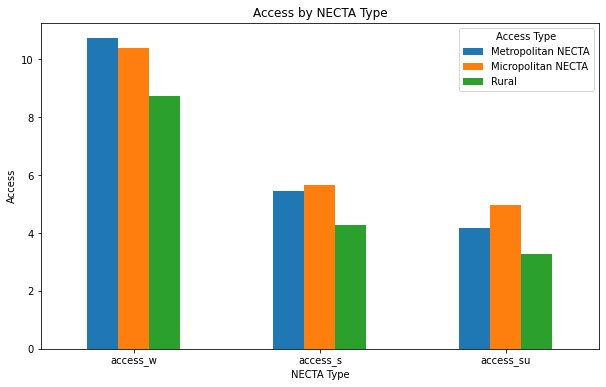

In [457]:
# Average Accessibility by Day and NECTA
mapping_df['necta'].fillna('Rural', inplace=True)
means_by_metro = mapping_df.groupby('necta').mean()
means_by_metro = means_by_metro[['access_w','access_s','access_su']]
print(means_by_metro)

# Make bar graph
means_by_metro_transposed = means_by_metro.T
means_by_metro_transposed.plot(kind='bar', figsize=(10, 6))
plt.title('Access by NECTA Type')
plt.xlabel('NECTA Type')
plt.ylabel('Access')
plt.xticks(rotation=0) 
plt.legend(title='Access Type')
plt.show()

# Report numbers for weekday
# Run sat rural / w rural and sat urban / w urban 

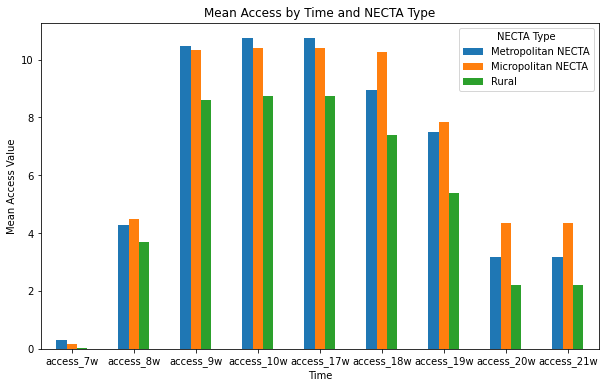

In [237]:
access_columns = ["access_7w", "access_8w", "access_9w", "access_10w", "access_17w","access_18w", "access_19w", "access_20w", "access_21w"]
bargraph_df = mapping_df.groupby('necta')[access_columns].mean()
bargraph_df = bargraph_df.T
#values = bargraph_df[access_columns].mean()  # Calculate the mean value for each access column

bargraph_df.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Access by Time and NECTA Type')
plt.xlabel('Time')
plt.ylabel('Mean Access Value')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='NECTA Type')
plt.show()

In [ ]:
# Add map showing access at midnight

### Elderly analysis

In [225]:
# Scatterplot pct_elderly vs acccessibility 
slope, intercept = np.polyfit(mapping_df['pct_elderly'], mapping_df['access_w'], 1)
regression_line = slope * mapping_df['pct_elderly'] + intercept

plt.scatter(mapping_df['pct_elderly'], mapping_df['access_w'], alpha=0.5) 
plt.plot(mapping_df['pct_elderly'], regression_line, color='red', label='Linear Regression')
plt.title('Scatter Plot: pct_elderly vs access_w')
plt.xlabel('Percentage of Elderly Population')
plt.ylabel('Access (Weekday)')
polt.legend()
plt.show()

SystemError: <class 'numpy.linalg.LinAlgError'> returned a result with an error set

## Results & Discussion

Extensive cleaning of unneccesary variables and lines of code that were never called.

### Making code more efficient and easier to read with GeoPandas

1. Made the __pop_centroid__ function much faster - preciosly took 3:30 to run, now less than a second. Instead of creating an empty GDF and iterating over all of the population geometries, adding data to this new GDF, I just used the native GeoPandas centroid method, replacing the population geometries with centroids, and then dropping other unnecessary columns from atrisk_data. 

2. Rewrote the __hospital_setting__ function to find each hospital's nearest node using GeoPandas nearest join method. What took 1:20 to run now runs in less than a second. I also cleaned the GDF so that it matched what we were working with before. 

### Removed parallel processing from two functions. 

1. __overlapping_function__
2. __measure_acc_par__

### Theoretical Changes to the methodology

Area weighted reaggregation - 
assigned speeds to the road network using osnmx. 

### Simplifying Code for future students

My greatest contribution to this replication has been the simplification of code and adding documentation to functions. This has made the code much easier for future students to read through and understand, and has not sacrificed processing times. I also made a visual workflow, visualizing the replication study from start to finish, including all data and functions used to manipulate them. 

Simplifications include:

I removed the dropdown menu that allows you to choose between population groups and hospital data. The benefits of this dropdown options were minimal, and it just made the code more confusing to follow and modify. In the form of a dropdown selection, it prevents the study from being one script, and introduces potential error as groups try to replicate eachother, if they are not clear about which choices they made with their mouse in the dropdown. 

I was able to delete the function __overlap_calc__, after implementing its function into __overlapping_function__ which was implements the area weighted reaggregation.

I removed a code block that filtered rows where the "hospital_icu_beds" value is infinity, which did not do anything. 



Classified Accessibility Outputs

### Conclusion

to be written.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.